FINAL MACHINE LEARNING


NAMA : NABILA RAMADHANTY

NIM : H071201006

**Customer Segementation Dengan Menggunakan K-Means Clustering**

**Step 1 : Importing the Library**

Hal pertama yang harus dilakukan adalah meng-import beberapa Library Python untuk kebutuhan dataframe, visualisasi dan clustering.

In [ ]:
# Library untuk dataframe dan visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# Import library untuk Clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Step 2 : Reading and Understanding the Data

Dataset OnlineRetail merupakan sekumpulan data transaksional dari toko-toko online/retail di UK yang terdaftar di suatu perusahaan retail online, dengan rentang waktu periode 1 Desember 2010 sampai dengan tanggal 9 Desember 2011.

In [ ]:
# Load dataset OnlineRetail
df = pd.read_csv('/content/Online Retail.csv', sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Berdasarkan output diatas, dapat disimpulkan bahwa dataset tersebut memiliki 8 atribut, diantaranya: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID dan Country.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Step 3 : Data Cleaning**

Langkah selanjutnya yaitu akan dilihat komposisi persentase missing value yang terdapat pada dataset,

In [ ]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

Berdasarkan output tersebut, dapat disimpulkan bahwa masih terdapat beberapa atribut yang memiliki missing value. Oleh karena itu, akan dilakukan penghapusan terhadap baris-baris yang mengandung missing value

In [ ]:
df = df.dropna()
df.shape

(406829, 8)

Pada output df.info(), diperoleh informasi bahwa atribut CustomerID memiliki tipe data float64, selanjutnya akan dilakukan pengubahan tipe data pada atribut tersebut menjadi str

In [ ]:
df['CustomerID'] = df.CustomerID.astype(str)

**Step 4 : Data Preparation**


Untuk memperoleh segmentasi dari atribut Customers, yang didasarkan pada 3 faktor berikut:

R (Recency) : Jumlah hari sejak pembelian terakhir
F (Frequency) : Jumlah ‘proses transaksi’
M (Monetary) : Jumlah total transaksi (kontribusi pendapatan)
Maka, langkah pertama yang harus dilakukan adalah membuat atribut baru “Monetary”

In [ ]:
# Membuat atribut baru : Monetary
df['Monetary'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# Membuat atribut baru : Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Akan dilakukan merging (penggabungan) antara dataframe rfm_m dan rmf_f

In [ ]:
# Menggabungkan (merging) dua dataframe
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Langkah selanjutnya, yaitu membuat atribut baru “Recency” dengan cara meng-convert tipe data atribut “InvoiceDate” menjadi datetime terlebih dahulu

In [ ]:
# Membuat atribut baru : Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M')

Kemudian, akan ditampilkan tanggal maksimal, untuk mengetahui tanggal terakhir kali melakukan transaksi

In [ ]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

Selanjutnya akan dihitung selisih nilai antara tanggal terakhir melakukan transaksi (max_date) dengan masing-masing tanggal yang terdapat di atribut “InvoiceDate”. Dimisalkan nilai selisih tersebut didefinisikan sebagai atribut baru “Diff”

In [ ]:
# Menghitung selisih antara max_date dengan InvoiceDate
df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


Selanjutnya, akan dihitung waktu terakhir customer melakukan transaksi guna mendefinisikan atribut Recency atau jumlah hari sejak pembelian terakhir.

In [ ]:
# Menghitung the last transaction date untuk atribut Recency
rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


Oleh karena, pada atribut Recency hanya dibutuhkan data terkait jumlah hari saja, maka selanjutnya akan dilakukan ekstraksi, atau hanya akan diambil data keterangan hari saja.

In [ ]:
# Extract jumlah hari
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


Setelah 3 atribut baru yaitu : Recency (dataframe : rfm_p), Frequency (dataframe : rfm_f) dan Monetary (dataframe : rfm_m) terbentuk, maka langkah selanjutnya yaitu menggabungkan ke-tiga atribut/ kolom tersebut menjadi RFM dataframe

In [ ]:
# Menggabungkan dataframe 
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Langkah selanjutnya akan dilakukan analisis terhadap outlier menggunakan boxplot

Text(0.5, 0, 'Attributes')

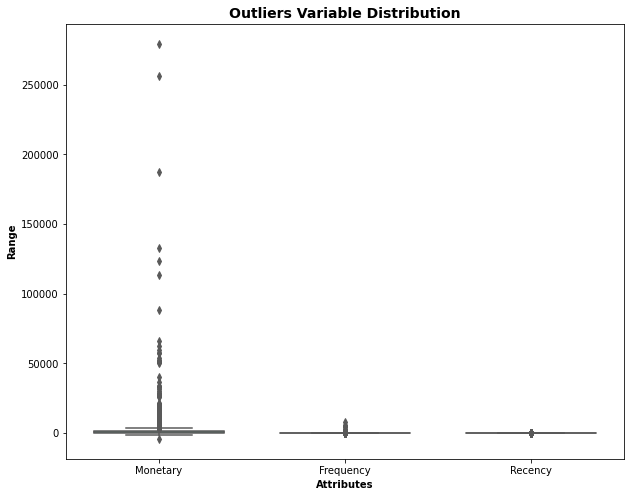

In [ ]:
# Outlier Analysis of Monetary, Frequency and Recency
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Boxplot merupakan ringkasan distribusi sampel yang disajikan secara grafis sebagai penggambaran bentuk distribusi data, ukuran tendensi sentral dan ukuran penyebaran (keragaman) data pengamatan. Selain itu boxplot juga bisa menunjukkan ada tidaknya nilai outlier dan nilai ekstrem di data pengamatan.

In [ ]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Untuk langkah selanjutnya, akan dilakukan penghapusan terhadap outliers yang ada

Tahap selanjutnya yaitu, akan dilakukan rescaling terhadap atribut-atribut yang ada. Rescaling atribut merupakan salah satu tahap yang penting agar masing-masing atribut memiliki skala yang sebanding. Pada case ini, akan digunakan Standardisation Scaling terhadap masing-masing atribut, dengan langkah sebagai berikut:

In [ ]:
# Rescaling Atribute
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


Output diatas merupakan hasil dari Standardisation Scaling yang telah dilakukan.

**Step 5 : Model Building**

Langkah selanjutnya, yaitu menentukan nilai K. Pada langkah ini, akan dikonfigurasi dan ditentukan nilai inisiasi k (n_clusters) sebesar 4 cluster.

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([2, 0, 3, ..., 2, 3, 3], dtype=int32)

Selanjutnya, akan dicari jumlah optimal dari cluster (k) dengan menggunakan metode Elbow Curve.

Elbow Curve, merupakan salah satu metode yang bisa digunakan untuk menemukan jumlah optimal dari cluster (k), yang langkah-langkah pengerjaan adalah sebagai berikut:

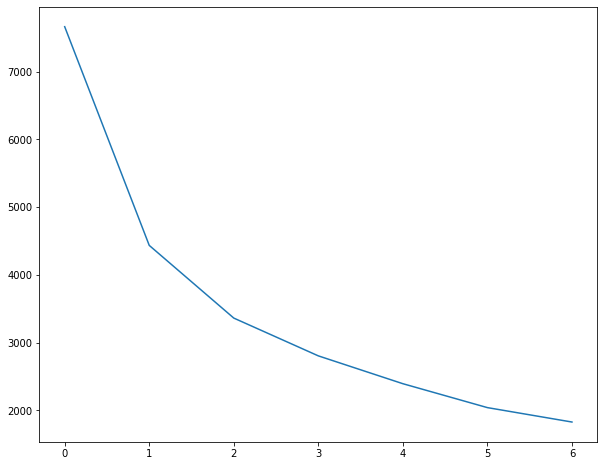

In [ ]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Pada elbow curve method, lokasi ‘tikungan’ yang terbentuk di plot, pada umumnya dianggap sebagai indikator jumlah cluster yang tepat [5].
Akan tetapi nilai k ‘optimal’ yang diperoleh dari metode elbow curve, sering kali bersifat “ambigu” atau belum pasti akan menghasilkan jumlah cluster (k) yang optimal.

Oleh karena itu, langkah selanjutnya akan digunakan Silhouette Analysis guna mencari nilai k optimal.

Nilai dari Sillhouette ada diantara -1 sampai dengan 1. Jika nilainya mendekati angka 1, maka titik data akan sangat mirip dengan titik data lainnya di cluster yang sama. Jika mendekati -1 maka titik data tersebut tidak mirip dengan titik data di klusternya.

In [ ]:
# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    
    # Initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    
    # Silhouette Score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816551560193964
For n_clusters=5, the silhouette score is 0.4658529685822305
For n_clusters=6, the silhouette score is 0.41698971636412085
For n_clusters=7, the silhouette score is 0.4151548412009542
For n_clusters=8, the silhouette score is 0.40192885592712724


Berdasarkan output tersebut, dapat disimpulkan bahwa untuk n_clusters=2 menghasilkan nilai silhouette yang tinggi.

In [ ]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=2)

In [ ]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# Assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


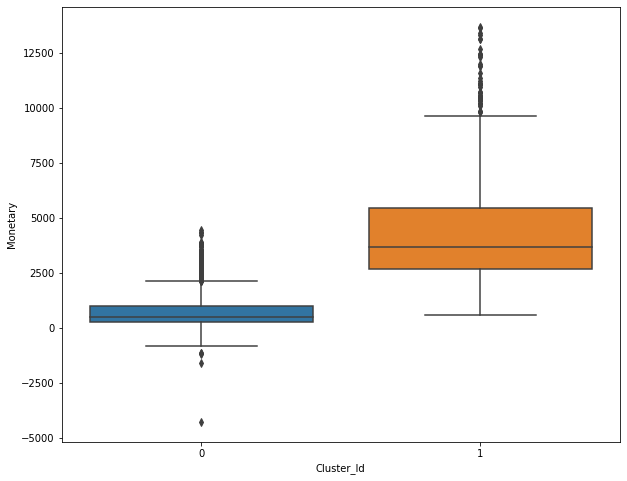

In [ ]:
# Boxplot untuk memvisualisasikan Cluster Id dan Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

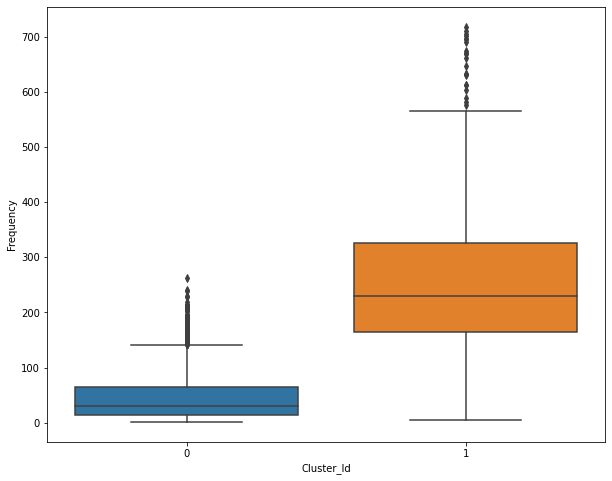

In [ ]:
# Boxplot untuk memvisualisasikan Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

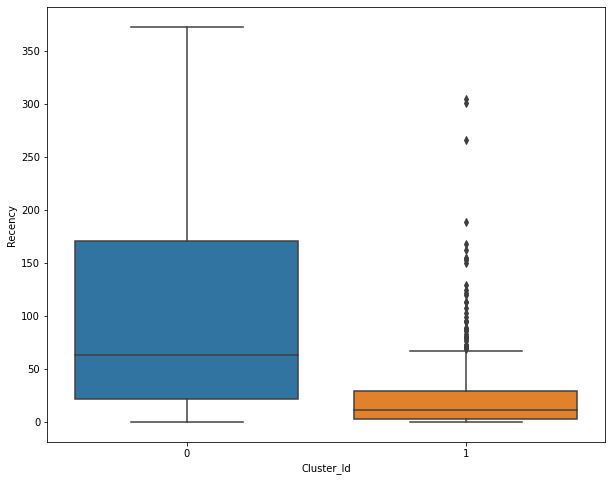

In [ ]:
# Boxplot untuk memvisualisasikan Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

Step 5 : Data Analysis

Berdasarkan langkah-langkah pengerjaan yang telah dilakukan, dapat disimpulkan bahwa:

Customers dengan Cluster Id 1 merupakan customer dengan jumlah total transaksi tinggi dibandingkan dengan customer lain.
Customers dengan Cluster Id 1 merupakan customer yang paling sering melakukan transaksi dibandingkan dengan customer di cluster lain